    TOPIC: Beyond News Headlines and TF-IDF: Enhancing Text-Based Forecasting Models with Validated Collocations and Improved Attention.
    Author: Gabriel Appau Abeyie

This code applies the method in **main_script_PVAM.ipynb** but using synthesized data using **fake_oil_news_dataset.csv** to perform uniqueness test.

In [73]:
import sys
import glob
import nltk
import unicodedata
import re
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from nltk import ngrams
from collections import Counter
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import f_regression
from scipy.stats import chi2_contingency
from sklearn.metrics import mean_squared_error
from itertools import product
from math import sqrt
from scipy.stats import ttest_1samp
from tabulate import tabulate
from statsmodels.tsa.ar_model import AutoReg
from matplotlib.patches import Rectangle
from bs4 import BeautifulSoup
from arabica import arabica_freq
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from arabica import cappuccino
from arabica import coffee_break
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import ne_chunk
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from pandas_datareader import data as pdr
from fredapi import Fred
fred = Fred(api_key='8c12312bfb1126571fa907077f4efe3c')
import yfinance as yf
yf.pdr_override()

In [74]:
oil_price = fred.get_series('DCOILWTICO', observation_start='1986-01-01', observation_end='2017-12-01')
monthly_oil = oil_price.resample('M').mean().ffill()
monthly_oil_log = np.log(monthly_oil)
monthly_oil_log_diff = monthly_oil_log.diff()
monthly_oil_log_diff = monthly_oil_log_diff.dropna()
print(monthly_oil_log_diff.head())

1986-02-28   -0.394332
1986-03-31   -0.203227
1986-04-30    0.018160
1986-05-31    0.180065
1986-06-30   -0.135741
Freq: M, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


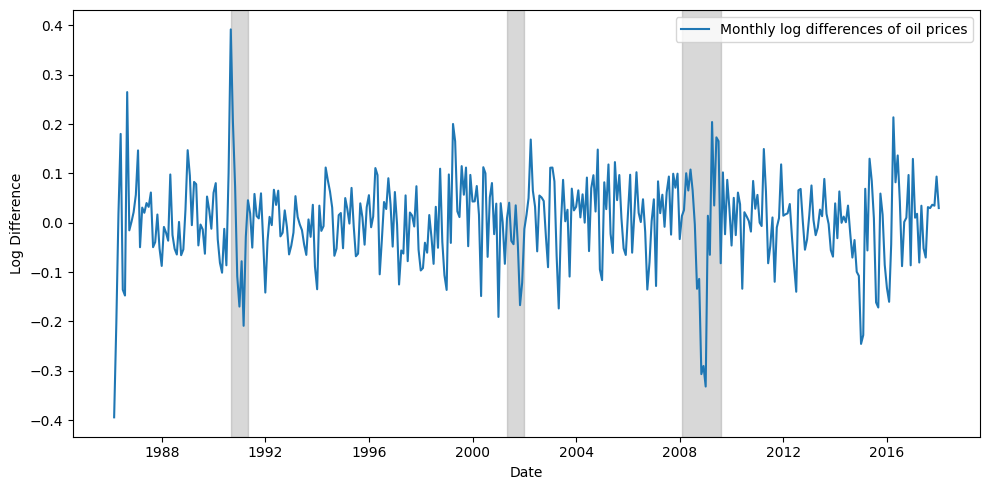

In [75]:
recessions = fred.get_series('USREC', observation_start='1986-01-01', observation_end='2017-12-01')
recessions = recessions.resample('M').last().ffill()

plt.figure(figsize=(10, 5))
plt.plot(monthly_oil_log_diff, label='Monthly log differences of oil prices')

for start, end in zip(recessions.index[recessions.diff() == 1], recessions.index[recessions.diff() == -1]):
    plt.axvspan(start, end, color='gray', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Log Difference')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('target.eps', dpi=600)
plt.show()

In [76]:
# Get the Sahm Rule Recession Indicator
sahn_index = fred.get_series('SAHMREALTIME', observation_start='1986-02-01', observation_end='2017-12-01')

# Initialize recession_expansion and update as matrices of True
recession_expansion = pd.DataFrame(True, index=sahn_index.index, columns=['indicator'])
update = recession_expansion.copy()

# Update recession_expansion: set to False if Sahm Rule Recession Indicator > 0.5
recession_expansion.loc[sahn_index > 0.5, 'indicator'] = False

# Update the update matrix: set to True only for the first time point and whenever the value of recession_expansion changes
update['indicator'] = recession_expansion['indicator'].ne(recession_expansion['indicator'].shift())
update['indicator'].iloc[0] = True

In [77]:
Fakenews = pd.read_csv('D:/Python/Untitled Folder/fake_oil_news_dataset.csv')
Target = monthly_oil_log_diff.values.ravel()  # Convert target DataFrame to 1D array

In [78]:
# create a dictionary mapping the incorrect forms to the correct ones
correction_dict = {
    "accord ing": "according",
    "interna tional": "international",
    "administra tion": "administration",
    "air line": "airline",
    "bar rel": "barrel",
    "invest ment": "investment",
    "bil lion": "billion",
    "mil lion": "million",
    "com pared": "compared",
    "com modities":"commodity",
    "commod ity": "commodity",
    "expecta tions": "expectation",
    "percent age": "percentage",
    "yorkcrude": "york crude",
    "ear lier": "earlier",
    "earn ings": "earnings",
    "econo mist": "economist",
    "euro pean": "european",
    "bar rels": "barrel",
    "pro ducer": "producer",
    "pro ducers": "producer",
    "pro gram": "program",
    "prob lem": "problem",
    "pro duction": "production",
    "daq": "nasdaq",
    "nasnasnasdaq": "nasdaq",
    "fri day": "friday",
    "fourth quarter": "fourthquarter",
    "prod ucts": "product",
    "quar ter": "quarter",
    "chi cago": "chicago",
    "ri ing": "rising",
    "sec ond": "second",
    "sec tor": "sector",
    "securi ties": "securitie",
    "securi tie": "securitie",
    "execu tive": "executive",
    "invest ment": "investment",
    "decem ber": "december",
    "janu ary": "january",
    "mar ket": "market",
    "sev eral": "several",
    "inven tory": "inventory",
    "sell ing": "selling",
    "trad er": "trader",
    "trad ing": "trading",
    "vol ume": "volume",
    "trea sury": "treasury",
    "invento ries": "inventory",
    "inves tor": "investor",
    "web site": "website",
    "invest ment": "investment",
    "invest ments": "investment",
    "yester day": "yesterday",
    "yes terday": "yesterday",
    "wednes day": "wednesday",
    "mer cantile": "mercantile",
    "mercan tile": "mercantile",
    "tues day": "tuesday",
    "mil lion": "million",
    "novem ber": "november",
    "sum mer": "summer",
    "stockindex": "stock index",
    "washingtonpost": "washington post",
    "contin ued": "continued",
    "crudeoil": "crude oil",
    "nasnasdaq": "nasdaq",
    "minuteminute": "minute minute",
    "futuresoptions": "future option",
    "includ ing": "including",
    "inter national": "international",
    "naturalgas": "natural gas",
    "oilbarrel": "oil barrel",
    "outnum bered": "outnumbered",
    "pres sure": "pressure",
    "presi dent": "president",
    "terest": "interest",
    "thur day": "thursday",
    "sup ply": "supply",
    "soy bean": "soybean",
    "inininterest": "interest",
    "ininterest": "interest",
    "fore cast": "forecast",
    "reve nue": "revenue",
    "peo ple": "people",
    "aver age": "average",
    "petro leum": "petroleum",
    "organiza tion": "organization",
    "pipe line": "pipeline",
    "nat ural": "natural",
    "ana lyst": "analyst",
    "ana lysts": "analyst",
    "buy ing": "buying",
    "natu ral": "natural",
    "busi ness": "business",
    "chair man": "chairman",
    "produc tion": "production",
    "ex porting": "exporting",
    "com panies": "company",
    "ara bia": "arabia",
    "larg est": "largest",
    "mem bers": "member",
    "mon day": "monday",
    "com pany": "company",
    "sep tember": "september",
    "septem ber": "september",
    "compa ny": "company",
    "com modity": "commodity",
    "ser vice": "service",
    "ser vices": "service",
    "set tled": "settled",
    "stan dard": "standard",
    "japa nese": "japanese",
    "eco nomic": "economic",
    "commodi tie": "commodity",
    "com posite": "composite",
    "compos ite": "composite",
    "cur rency": "currency",
    "cur rent": "current",
    "bench mark": "benchmark",
    "coun try": "country",
    "fed eral": "federal",
    "japa nese": "japanese",
    "export ing": "exporting",
    "deliv ery": "delivery",
    "depart ment": "department",
    "heatingoil": "heating oil",
    "heat ing": "heating",
    "bluechip": "blue chip",
    "divi sion": "division",
    "dol lar": "dollar",
    "dur ing": "during",
    "harmon": "harman",
    "inter est": "interest",
    "econ omy": "economy",
    "esti mate": "estimate",
    "febru ary": "february",
    "finan cial": "financial",
    "fur ther": "further",
    "gal lon": "gallon",
    "investment officer albany": "investment officer first albany",
    "point face yield": "face yield",
    "gaso line": "gasoline",
    "glo bal": "global",
    "second quarter": "secondquarter",
    "smaller company": "smallercompany", 
    "govern ment": "government",
    "gov ernment": "government",
    "include ing": "including",
    "indus trial": "industrial",
    "indus try": "industry",
    "infla tion": "inflation",
    "novem ber": "november",
    "octo ber": "october",
    "organi zation": "organization",
    "offi cials": "official",
    "manage ment": "management",
    "tech nology": "technology",
    "big gest": "biggest",
    "opera tions": "operation",
    "insti tute": "institute",
    "prec metal indus": "precious metal industry",
    "york stock change": "york stock exchange",
    "mor gan": "morgan"
}

# define a function to apply the corrections
def correct_words(text):
    for incorrect, correct in correction_dict.items():
        text = text.replace(incorrect, correct)
    return text

# apply the function to your text column
Fakenews['cleaned_Text'] = Fakenews['cleaned_Text'].apply(correct_words)

In [79]:
corpus = ' '.join(Fakenews['cleaned_Text'])
# Generate dates for x-axis
base_dates = pd.date_range(start="1986-01", end="2017-12", freq='M')
oos_base_dates = pd.date_range(start="2006-01", end="2018-01", freq='M')

In [80]:
def get_ngramrange_df(df, min_df, tfidf_min, split_ratio, ngram_range):
    # Split the data based on split ratio
    split_index = int(len(df) * split_ratio)
    df_train = df.iloc[:split_index]
    df_test = df.iloc[split_index:]

    # Create an instance of the TfidfVectorizer class with specified ngram range
    vectorizer_tfidf_combined = TfidfVectorizer(analyzer="word", ngram_range=ngram_range, min_df=min_df, stop_words='english')

    # Fit the vectorizer on the training dataset and transform training dataset
    X_tfidf_train = vectorizer_tfidf_combined.fit_transform(df_train['cleaned_Text'])
    
    # Convert the resulting matrices to DataFrames with appropriate column names
    columns = vectorizer_tfidf_combined.get_feature_names_out()
    df_tfidf_train = pd.DataFrame(X_tfidf_train.toarray(), columns=columns)

    # Calculate the total sum of TF-IDF values for each n-gram and filter n-grams with total TF-IDF >= 1.0
    df_total_tfidf = df_tfidf_train.sum().reset_index()
    df_total_tfidf.columns = ['ngram', 'total_tfidf']
    ngrams_with_total_tfidf_above_one = df_total_tfidf[df_total_tfidf['total_tfidf'] >= tfidf_min]['ngram'].tolist()

    # Create a CountVectorizer instance using the filtered n-grams
    vectorizer_count = CountVectorizer(vocabulary=ngrams_with_total_tfidf_above_one, ngram_range=ngram_range, stop_words='english')

    # Fit and transform the data using the count vectorizer
    X_count_train = vectorizer_count.fit_transform(df_train['cleaned_Text'])
    X_count_test = vectorizer_count.transform(df_test['cleaned_Text'])

    # Convert the resulting matrices to DataFrames with appropriate column names
    df_count_train = pd.DataFrame(X_count_train.toarray(), columns=vectorizer_count.get_feature_names_out())
    df_count_test = pd.DataFrame(X_count_test.toarray(), columns=vectorizer_count.get_feature_names_out())

    return df_count_train, df_count_test

In [81]:
X_train, X_test = get_ngramrange_df(Fakenews, ngram_range =(1,2), min_df=0.01, tfidf_min=0.50, split_ratio=0.625)
X_columns = X_train.columns.tolist()

In [82]:
# Initialize lists for unigrams and bigrams
unigrams = []
bigrams = []

# Split X_columns into unigrams and bigrams
for phrase in X_columns:
    words = phrase.split(' ')
    if len(words) == 1:
        unigrams.append(phrase)
    elif len(words) == 2:
        bigrams.append(phrase)
    else:
        print(f"Unexpected number of words in phrase: {phrase}")

In [83]:
# Validating the collocations

#Justeson and Katz pattern
def is_adj_noun_or_noun_noun(ngram):
    words = nltk.word_tokenize(ngram)
    pos_tags = [tag for word, tag in nltk.pos_tag(words)]
    # Check for adjective + noun or noun + noun patterns
    return (pos_tags == ['JJ', 'NN'] or pos_tags == ['NN', 'NN'])

def is_verb_noun_or_adv_adj(bigram):
    words = nltk.word_tokenize(bigram)
    pos_tags = [tag for word, tag in nltk.pos_tag(words)]
    # Check for verb + noun, adverb + adjective, and noun + verb
    return pos_tags in [['VB', 'NN'], ['VBD', 'NN'], ['VBG', 'NN'], ['VBN', 'NN'], ['VBP', 'NN'], ['VBZ', 'NN'], 
                        ['RB', 'JJ'], ['RBR', 'JJ'], ['RBS', 'JJ']]
    
# Use the function to filter bigrams
jk_bigrams = [bigram for bigram in bigrams if is_adj_noun_or_noun_noun(bigram)]
vn_bigrams = [bigram for bigram in bigrams if is_verb_noun_or_adv_adj(bigram)]

In [84]:
X_jk_columns = unigrams + jk_bigrams
X_vn_columns = unigrams + vn_bigrams

In [85]:
X_unigrams_only_train = X_train[unigrams]
X_unigrams_only_test = X_test[unigrams]
X_jk_train = X_train[X_jk_columns]
X_jk_test = X_test[X_jk_columns]
X_vn_train = X_train[X_vn_columns]
X_vn_test = X_test[X_vn_columns]

In [86]:
import numpy as np

# Remove first row of the training sets
X_train = X_train.iloc[1:, :]
X_jk_train = X_jk_train.iloc[1:, :]
X_vn_train = X_vn_train.iloc[1:, :]

# Convert all sets to arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
X_jk_train = np.array(X_jk_train)
X_jk_test = np.array(X_jk_test)
X_vn_train = np.array(X_vn_train)
X_vn_test = np.array(X_vn_test)

In [87]:
datasets = {r'Targeted Fake News Features ($F^{*}_{1,t}$)': (X_train, X_test),
            r'N-N/A-N Targeted Fake News Features ($F^{*}_{2,t}$)': (X_jk_train, X_jk_test),
            r'V-N/Av-A Targeted Fake News Features ($F^{*}_{3,t}$)':(X_vn_train, X_vn_test)
            }

To determine the number of factors to employ in our principal component analysis (PCA), we adopt a method proposed by Ahn and Horstein (2013) and select upto the second largest (to be conservative) Eigen-value Ratio (ER) or Growth Ratio (GR) for robustness check. We set our $kmax$ to 8. Below are the formulas:
$$
\mathrm{ER}(k) \equiv \frac{\tilde{\mu}_{N T \cdot k}}{\tilde{\mu}_{N T, k+1}}, \quad k=1,2, \ldots, k \max
$$

In [88]:
def num_factors(data, kmax):
    T, N = data.shape
    K = min(kmax, N)

    xx = (data.T @ data) / (T*N) if N < T else (data @ data.T) / (T*N)

    eig_values = np.linalg.eigvals(xx)
    d = sorted(eig_values, reverse=True)

    ER = [d[k] / d[k+1] for k in range(K-1)]
    ER = [0 if np.isnan(e) or np.isinf(e) else e for e in ER]
    
    n_fac = max(ER)
    #n_fac = np.partition(ER, -2)[-2]
    
    num_factors = ER.index(n_fac) + 1 # Remember python indexing starts from 0 so +1

    return num_factors

$$
\begin{aligned}
\operatorname{GR}(k) & =\frac{\ln [V(k-1) / V(k)]}{\ln [V(k) / V(k+1)]} \\
& =\frac{\ln \left(1+\bar{\mu}_{N T_k}^*\right)}{\ln \left(1+\bar{\mu}_{N T, k+1}\right)}, \quad k=1,2, \ldots, k \max ,
\end{aligned}
$$
Where $V(k)=\sum_{l=k+1}^m \tilde{\mu}_{N T, f}$ and $\tilde{\mu}_{N T k}^*=\tilde{\mu}_{N T, k} / V(k)$.

In [89]:
import numpy as np

def num_factors_gr(data, kmax):
    T, N = data.shape
    K = min(kmax, N)

    xx = (data.T @ data) / (T*N) if N < T else (data @ data.T) / (T*N)

    eig_values = np.linalg.eigvals(xx)
    d = sorted(eig_values, reverse=True)

    V = [sum(d[k+1:]) for k in range(K)]
    mu_star = [d[k] / V[k] for k in range(K-1)]
    
    GR = [np.log(1 + mu_star[k]) / np.log(1 + (d[k+1] / V[k+1])) for k in range(K-2)]
    GR = [0 if np.isnan(g) or np.isinf(g) else g for g in GR]
    
    n_fac_gr = np.partition(GR, -2)[-2]
    
    num_factors_gr = GR.index(n_fac_gr) + 1 # Remember python indexing starts from 0 so +1

    return num_factors_gr

                                                                            ATTENTION MECHANISM MODEL

In [90]:
# Initialize your objects
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
scaler = StandardScaler()
horizons = [1, 3, 6, 9]

# Placeholder for storing all values for each horizon and each model
predictions_dict_pca = {}
y_true_dict_pca = {}

# Loop over datasets
for model_name, (train, test) in datasets.items():
    predictions_dict_pca[model_name] = {h: [] for h in horizons}
    y_true_dict_pca[model_name] = {h: [] for h in horizons}

    # Concatenate train and test
    data = np.concatenate([train, test])

    # Initialize the model outside the loop
    model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=tscv, max_iter=10000, tol=0.0001)
    
    # Define a variable to keep track of the last observed value of the recession indicator
    last_indicator = None

    # Loop over horizons
    for h in horizons:
        y_true_per_pca_horizon = []
        y_pred_per_pca_horizon = []

        # Loop over time points in the test set
        for i in range(len(train), len(data) - h + 1):
            # Get train and test data up to the forecast origin
            train_temp = data[:i]
            test_temp = data[i:i+h]

            # Get the corresponding targets
            y_train_temp = Target[:i]
            y_test_temp = Target[i:i+h]

            # Standardize the data
            scaler.fit(train_temp)
            train_temp_standardized = scaler.transform(train_temp)
            test_temp_standardized = scaler.transform(test_temp)
            
            # Check if we should update the model (i.e., if there is a change in the recession_indicator)
            current_indicator = update['indicator'][i]
            if i == 0 or current_indicator != last_indicator:
                # Update the last observed value of the recession indicator
                last_indicator = current_indicator
                
                # Train the model
                model.fit(train_temp_standardized, np.ravel(y_train_temp))

                # If no features were selected, refit the model with a different l1_ratio
                refit_attempts = 0
                while len(np.nonzero(model.coef_)[0]) <= 1 and refit_attempts < 2:
                    model.set_params(l1_ratio = 0.0000000001)  # Choose a suitable l1_ratio
                    model.fit(train_temp_standardized, np.ravel(y_train_temp))
                    refit_attempts += 1

                # If still no features were selected after 2 attempts, print a warning
                if len(np.nonzero(model.coef_)[0]) <= 1:
                    print(f'Warning: Model failed to select more than one feature after {refit_attempts} attempts.')

            # If any features were selected, apply PCA
            if model.coef_.any():
                # Get indices of non-zero coefficients
                selected_features = np.nonzero(model.coef_)[0]
                
                # Select the features that were not discarded by the ElasticNet
                selected_train_temp = train_temp[:, selected_features]
                selected_test_temp = test_temp[:, selected_features]

                # Initialize and fit a new scaler on the selected features
                scaler_pca = StandardScaler()
                scaler_pca.fit(selected_train_temp)
                
                # Standardize selected features
                selected_train_temp_standardized = scaler_pca.transform(selected_train_temp)
                selected_test_temp_standardized = scaler_pca.transform(selected_test_temp)

                # Define PCA
                n_components = num_factors(selected_train_temp_standardized, kmax=8)  # Choose a suitable value for kmax
                pca = PCA(n_components= n_components)
                best_pca = pca.fit(selected_train_temp_standardized)

                # Transform data using the best PCA
                selected_train_temp_pca = best_pca.transform(selected_train_temp_standardized)
                selected_test_temp_pca = best_pca.transform(selected_test_temp_standardized)

                # Train a linear regression model and compute p-values
                lr = LinearRegression()

                # Calculate p-values
                mod = sm.OLS(np.ravel(y_train_temp), sm.add_constant(selected_train_temp_pca))
                fii = mod.fit()
                p_values = fii.summary2().tables[1]['P>|t|']

                # Find the significant features
                significant_features = p_values[p_values < 0.05].index  # Find features with p-value < 0.05

                # Ignore the constant term
                significant_features = [i for i in significant_features if i != 'const']

                # Create a mapping from column names to indices
                column_to_index = {col: idx-1 for idx, col in enumerate(fii.summary2().tables[1].index)}  # idx-1 corrects for the added constant

                # Convert column names to indices
                significant_indices = [column_to_index[col] for col in significant_features if column_to_index[col] != -1]  # We make sure not to include the constant

                # If there are significant features, retrain the model on these
                if significant_indices:
                    selected_train_temp_pca = selected_train_temp_pca[:, significant_indices]
                    selected_test_temp_pca = selected_test_temp_pca[:, significant_indices]
                else:
                    print("No features with p-value < 0.05 was found. Retaining all PCA-transformed features.")

                # Fit the model on the selected (or all) PCA-transformed features
                lr.fit(selected_train_temp_pca, np.ravel(y_train_temp))
                
                # Make a prediction and add it to the predictions list
                y_pred_pca_temp = lr.predict(selected_test_temp_pca)
                y_pred_per_pca_horizon.append(y_pred_pca_temp[h-1]) # Remember python indexing starts from 0

                # Add true values to a list
                y_true_per_pca_horizon.append(y_test_temp[h-1]) # Remember python indexing starts from 0

        predictions_dict_pca[model_name][h] = y_pred_per_pca_horizon
        y_true_dict_pca[model_name][h] = y_true_per_pca_horizon

# Save dictionaries to files for future use
with open('predictions_dict_pca.pkl', 'wb') as f:
    pickle.dump(predictions_dict_pca, f)
with open('y_true_dict_pca.pkl', 'wb') as f:
    pickle.dump(y_true_dict_pca, f)

No features with p-value < 0.05 was found. Retaining all PCA-transformed features.
No features with p-value < 0.05 was found. Retaining all PCA-transformed features.
No features with p-value < 0.05 was found. Retaining all PCA-transformed features.
No features with p-value < 0.05 was found. Retaining all PCA-transformed features.
No features with p-value < 0.05 was found. Retaining all PCA-transformed features.
No features with p-value < 0.05 was found. Retaining all PCA-transformed features.
No features with p-value < 0.05 was found. Retaining all PCA-transformed features.
No features with p-value < 0.05 was found. Retaining all PCA-transformed features.
No features with p-value < 0.05 was found. Retaining all PCA-transformed features.
No features with p-value < 0.05 was found. Retaining all PCA-transformed features.
No features with p-value < 0.05 was found. Retaining all PCA-transformed features.
No features with p-value < 0.05 was found. Retaining all PCA-transformed features.
No f

In [91]:
# Loop over models
for model_name in predictions_dict_pca.keys():
    print(f'Model: {model_name}')
    
    # Loop over horizons
    for h in predictions_dict_pca[model_name].keys():
        # Get the length of the list of predictions for this model and horizon
        num_predictions = len(predictions_dict_pca[model_name][h])
        
        # Print the number of predictions
        print(f'Horizon {h}: {num_predictions} predictions')
        
    # Print a blank line for readability
    print()

Model: Targeted Fake News Features ($F^{*}_{1,t}$)
Horizon 1: 144 predictions
Horizon 3: 142 predictions
Horizon 6: 139 predictions
Horizon 9: 136 predictions

Model: N-N/A-N Targeted Fake News Features ($F^{*}_{2,t}$)
Horizon 1: 144 predictions
Horizon 3: 142 predictions
Horizon 6: 139 predictions
Horizon 9: 136 predictions

Model: V-N/Av-A Targeted Fake News Features ($F^{*}_{3,t}$)
Horizon 1: 144 predictions
Horizon 3: 142 predictions
Horizon 6: 139 predictions
Horizon 9: 136 predictions



In [92]:
# Loop over models
for model_name in y_true_dict_pca.keys():
    print(f'Model: {model_name}')
    
    # Loop over horizons
    for h in y_true_dict_pca[model_name].keys():
        # Get the length of the list of oss obs for this model and horizon
        num_oos = len(y_true_dict_pca[model_name][h])
        
        # Print the number of obs
        print(f'Horizon {h}: {num_oos} Out-of-sample Observations')
        
    # Print a blank line for readability
    print()

Model: Targeted Fake News Features ($F^{*}_{1,t}$)
Horizon 1: 144 Out-of-sample Observations
Horizon 3: 142 Out-of-sample Observations
Horizon 6: 139 Out-of-sample Observations
Horizon 9: 136 Out-of-sample Observations

Model: N-N/A-N Targeted Fake News Features ($F^{*}_{2,t}$)
Horizon 1: 144 Out-of-sample Observations
Horizon 3: 142 Out-of-sample Observations
Horizon 6: 139 Out-of-sample Observations
Horizon 9: 136 Out-of-sample Observations

Model: V-N/Av-A Targeted Fake News Features ($F^{*}_{3,t}$)
Horizon 1: 144 Out-of-sample Observations
Horizon 3: 142 Out-of-sample Observations
Horizon 6: 139 Out-of-sample Observations
Horizon 9: 136 Out-of-sample Observations



                                                                    HISTORICAL AVERAGE BENCHMAKR MODEL

In [93]:
# Placeholder for storing all values for each horizon and each model
predictions_historical_avg_dict = {}
y_true_historical_avg_dict = {}

# Loop over datasets
for model_name, (train, test) in datasets.items():
    predictions_historical_avg_dict[model_name] = {h: [] for h in horizons}
    y_true_historical_avg_dict[model_name] = {h: [] for h in horizons}

    # Concatenate train and test
    data = np.concatenate([train, test])

    # Loop over horizons
    for h in horizons:
        y_true_historical_per_horizon = []
        y_pred_historical_per_horizon = []

        # Loop over time points in the test set
        for i in range(len(train), len(data) - h + 1):
            # Get the corresponding targets
            y_train_temp = Target[:i]
            y_test_temp = Target[i:i+h]

            # Compute historical average
            historical_avg = np.mean(y_train_temp)

            # Use historical average as prediction
            y_pred_temp = np.full(h, historical_avg)

            # Append prediction and true value to lists
            y_pred_historical_per_horizon.append(y_pred_temp[h-1])
            y_true_historical_per_horizon.append(y_test_temp[h-1])

        # Store predictions and true values for this horizon
        predictions_historical_avg_dict[model_name][h] = y_pred_historical_per_horizon
        y_true_historical_avg_dict[model_name][h] = y_true_historical_per_horizon 

# Save dictionaries to files for future use
with open('predictions_historical_avg_dict.pkl', 'wb') as f:
    pickle.dump(predictions_historical_avg_dict, f)
with open('y_true_historical_avg_dict.pkl', 'wb') as f:
    pickle.dump(y_true_historical_avg_dict, f)

                                                                AUTOREGRESSIVE BENCHMARK MODEL

In [94]:
# Placeholder for storing all values for each horizon and each model
predictions_ar_dict = {}
y_true_ar_dict = {}

# Loop over datasets
for model_name, (train, test) in datasets.items():
    predictions_ar_dict[model_name] = {h: [] for h in horizons}
    y_true_ar_dict[model_name] = {h: [] for h in horizons}

    # Concatenate train and test
    data = np.concatenate([train, test])

    # Loop over horizons
    for h in horizons:
        y_true_per_ar_horizon = []
        y_pred_per_ar_horizon = []

        # Loop over time points in the test set
        for i in range(len(train), len(data) - h + 1):
            # Get the corresponding targets
            y_train_temp = Target[:i]
            y_test_temp = Target[i:i+h]

            # Determine the order of the AR model using AIC
            AIC = []
            for p in range(1, 10):  # for simplicity, consider orders up to 10
                model_temp = AutoReg(y_train_temp, lags=p, old_names=False)
                result_temp = model_temp.fit()
                AIC.append(result_temp.aic)
            optimal_p = np.argmin(AIC) + 1

            # Fit the AR model of order optimal_p
            model_ar = AutoReg(y_train_temp, lags=optimal_p, old_names=False)
            result_ar = model_ar.fit()

            # Make a prediction and add it to the predictions list
            y_pred_temp = result_ar.predict(start=len(y_train_temp), end=len(y_train_temp)+h-1)
            y_pred_per_ar_horizon.append(y_pred_temp[h-1])

            # Append true value to list
            y_true_per_ar_horizon.append(y_test_temp[h-1])

        # Store predictions and true values for this horizon
        predictions_ar_dict[model_name][h] = y_pred_per_ar_horizon
        y_true_ar_dict[model_name][h] = y_true_per_ar_horizon 

# Save dictionaries to files for future use
with open('predictions_ar_dict.pkl', 'wb') as f:
    pickle.dump(predictions_ar_dict, f)
with open('y_true_ar_dict.pkl', 'wb') as f:
    pickle.dump(y_true_ar_dict, f)

                                                        RELATIVE ROOT MEAN SQUARE ERROR WITH HISTORICAL AVERAGE BENCHMARK MODEL

In [95]:
# Placeholder for storing RMSFE for each horizon and each model
rmsfe_dict = {}
rrmsfe_dict = {}

# Loop over datasets
for model_name, _ in datasets.items():
    rmsfe_dict[model_name] = {h: 0 for h in horizons}
    rrmsfe_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_dict_pca[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_historical_avg_dict[model_name][h])
        
        # Calculate MSFE for this model and benchmark model
        msfe_model = np.mean((y_true - y_pred)**2)
        msfe_benchmark = np.mean((y_true - y_benchmark)**2)

        rmsfe_model = sqrt(msfe_model)
        
        # Calculate RRMSFE for this model
        rrmsfe_model = sqrt(msfe_model / msfe_benchmark)

        # Store MSFE and RRMSFE for this horizon
        rmsfe_dict[model_name][h] = rmsfe_model
        rrmsfe_dict[model_name][h] = rrmsfe_model

print("\nRelative Root Mean Squared Forecast Errors (RRMSFE) against HA:")
for model_name, rrmsfe_values in rrmsfe_dict.items():
    print(f"\nModel: {model_name}")
    for h, rrmsfe in rrmsfe_values.items():
        print(f"Horizon {h}: {rrmsfe:.3f}")  # .4f is for displaying only up to 4 decimal places


Relative Root Mean Squared Forecast Errors (RRMSFE) against HA:

Model: Targeted Fake News Features ($F^{*}_{1,t}$)
Horizon 1: 1.002
Horizon 3: 0.997
Horizon 6: 0.998
Horizon 9: 1.000

Model: N-N/A-N Targeted Fake News Features ($F^{*}_{2,t}$)
Horizon 1: 0.997
Horizon 3: 0.998
Horizon 6: 1.000
Horizon 9: 1.000

Model: V-N/Av-A Targeted Fake News Features ($F^{*}_{3,t}$)
Horizon 1: 0.996
Horizon 3: 0.999
Horizon 6: 1.000
Horizon 9: 0.999


                                                    RELATIVE ROOT MEAN SQUARE ERROR WITH AUTOREGRESSIVE BENCHMARK MODEL

In [96]:
# Placeholder for storing RMSFE for each horizon and each model
rmsfe_dict = {}
rrmsfe_dict = {}

# Loop over datasets
for model_name, _ in datasets.items():
    rmsfe_dict[model_name] = {h: 0 for h in horizons}
    rrmsfe_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_ar_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_ar_dict[model_name][h])
        
        # Calculate MSFE for this model and benchmark model
        msfe_model = np.mean((y_true - y_pred)**2)
        msfe_benchmark = np.mean((y_true - y_benchmark)**2)

        rmsfe_model = sqrt(msfe_model)
        
        # Calculate RRMSFE for this model
        rrmsfe_model = sqrt(msfe_model / msfe_benchmark)

        # Store MSFE and RRMSFE for this horizon
        rmsfe_dict[model_name][h] = rmsfe_model
        rrmsfe_dict[model_name][h] = rrmsfe_model

print("\nRelative Root Mean Squared Forecast Errors (RRMSFE) against AR(p):")
for model_name, rrmsfe_values in rrmsfe_dict.items():
    print(f"\nModel: {model_name}")
    for h, rrmsfe in rrmsfe_values.items():
        print(f"Horizon {h}: {rrmsfe:.3f}")  # .4f is for displaying only up to 4 decimal places


Relative Root Mean Squared Forecast Errors (RRMSFE) against AR(p):

Model: Targeted Fake News Features ($F^{*}_{1,t}$)
Horizon 1: 1.048
Horizon 3: 0.992
Horizon 6: 1.002
Horizon 9: 0.999

Model: N-N/A-N Targeted Fake News Features ($F^{*}_{2,t}$)
Horizon 1: 1.042
Horizon 3: 0.993
Horizon 6: 1.003
Horizon 9: 1.000

Model: V-N/Av-A Targeted Fake News Features ($F^{*}_{3,t}$)
Horizon 1: 1.042
Horizon 3: 0.995
Horizon 6: 1.004
Horizon 9: 0.999


                                            OUT OF SAMPLE R-SQUARED WITH HISTORICAL AVERAGE BENCHMARK MODEL

In [97]:
# Placeholder for storing o-o-s R-squared for each horizon and each model
r2_oos_dict = {}

# Loop over each model
for model_name in predictions_dict_pca.keys():
    r2_oos_dict[model_name] = {}
    # Loop over each horizon
    for h in horizons:
        # Get true values and predictions for this model and horizon
        y_true = np.array(y_true_historical_avg_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])

        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_historical_avg_dict[model_name][h])

        # Calculate MSPE for the model and benchmark
        mspe_model = np.mean((y_true - y_pred)**2)
        mspe_benchmark = np.mean((y_true - y_benchmark)**2)

        # Calculate R^2_oos
        r2_oos = (1 - (mspe_model / mspe_benchmark))*100

        r2_oos_dict[model_name][h] = r2_oos

print("\nOut-of-sample R-squared (OOS-Rsq) against HA:")
for model_name, oos_values in r2_oos_dict.items():
    print(f"\nModel: {model_name}")
    for h, oos in oos_values.items():
        print(f"Horizon {h}: {oos:.2f}")  # .4f is for displaying only up to 4 decimal places


Out-of-sample R-squared (OOS-Rsq) against HA:

Model: Targeted Fake News Features ($F^{*}_{1,t}$)
Horizon 1: -0.43
Horizon 3: 0.56
Horizon 6: 0.31
Horizon 9: 0.10

Model: N-N/A-N Targeted Fake News Features ($F^{*}_{2,t}$)
Horizon 1: 0.66
Horizon 3: 0.32
Horizon 6: 0.07
Horizon 9: -0.00

Model: V-N/Av-A Targeted Fake News Features ($F^{*}_{3,t}$)
Horizon 1: 0.73
Horizon 3: 0.10
Horizon 6: 0.01
Horizon 9: 0.13


                                                    OUT OF SAMPLE R-SQUARED WITH AUTOREGRESSIVE BENCHMARK MODEL

In [98]:
# Placeholder for storing o-o-s R-squared for each horizon and each model
r2_oos_dict = {}

# Loop over each model
for model_name in predictions_dict_pca.keys():
    r2_oos_dict[model_name] = {}
    # Loop over each horizon
    for h in horizons:
        # Get true values and predictions for this model and horizon
        y_true = np.array(y_true_ar_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])

        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_ar_dict[model_name][h])

        # Calculate MSPE for the model and benchmark
        mspe_model = np.mean((y_true - y_pred)**2)
        mspe_benchmark = np.mean((y_true - y_benchmark)**2)

        # Calculate R^2_oos
        r2_oos = (1 - (mspe_model / mspe_benchmark))*100

        r2_oos_dict[model_name][h] = r2_oos

print("\nOut-of-sample R-squared (OOS-Rsq) against AR(p):")
for model_name, oos_values in r2_oos_dict.items():
    print(f"\nModel: {model_name}")
    for h, oos in oos_values.items():
        print(f"Horizon {h}: {oos:.2f}")  # .4f is for displaying only up to 4 decimal places


Out-of-sample R-squared (OOS-Rsq) against AR(p):

Model: Targeted Fake News Features ($F^{*}_{1,t}$)
Horizon 1: -9.80
Horizon 3: 1.55
Horizon 6: -0.42
Horizon 9: 0.17

Model: N-N/A-N Targeted Fake News Features ($F^{*}_{2,t}$)
Horizon 1: -8.62
Horizon 3: 1.31
Horizon 6: -0.66
Horizon 9: 0.07

Model: V-N/Av-A Targeted Fake News Features ($F^{*}_{3,t}$)
Horizon 1: -8.54
Horizon 3: 1.09
Horizon 6: -0.73
Horizon 9: 0.20


In [99]:
from dieboldmariano import dm_test

# Placeholder for storing DM test results for each horizon and each model
dm_test_results_dict = {}

# Loop over datasets
for model_name, _ in datasets.items():
    dm_test_results_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_ar_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_ar_dict[model_name][h])
        
        # Compute the prediction errors
        model_errors = y_true - y_pred
        benchmark_errors = y_true - y_benchmark

        # Perform the Diebold-Mariano test
        dm_stat, p_value = dm_test(y_true, y_pred, y_benchmark, one_sided = True)

        # Store the DM test results
        dm_test_results_dict[model_name][h] = (dm_stat, p_value) # Negative for greater than one-sided

print("\nDiebold-Mariano test results aginst AR(p):")
for model_name, dm_results in dm_test_results_dict.items():
    print(f"\nModel: {model_name}")
    for h, (dm_stat, p_value) in dm_results.items():
        print(f"Horizon {h}: DM Statistic: {dm_stat:.3f}, p-value: {p_value:.3f}")  # .3f is for displaying only up to 3 decimal places



Diebold-Mariano test results aginst AR(p):

Model: Targeted Fake News Features ($F^{*}_{1,t}$)
Horizon 1: DM Statistic: 1.354, p-value: 0.911
Horizon 3: DM Statistic: -0.411, p-value: 0.341
Horizon 6: DM Statistic: 0.172, p-value: 0.568
Horizon 9: DM Statistic: -0.206, p-value: 0.419

Model: N-N/A-N Targeted Fake News Features ($F^{*}_{2,t}$)
Horizon 1: DM Statistic: 1.201, p-value: 0.884
Horizon 3: DM Statistic: -0.349, p-value: 0.364
Horizon 6: DM Statistic: 0.271, p-value: 0.607
Horizon 9: DM Statistic: -0.080, p-value: 0.468

Model: V-N/Av-A Targeted Fake News Features ($F^{*}_{3,t}$)
Horizon 1: DM Statistic: 1.197, p-value: 0.883
Horizon 3: DM Statistic: -0.296, p-value: 0.384
Horizon 6: DM Statistic: 0.282, p-value: 0.611
Horizon 9: DM Statistic: -0.235, p-value: 0.407


In [100]:
from scipy import stats

# Placeholder for storing Clark-West test results for each horizon and each model
cw_test_results_dict = {}

# Loop over datasets
for model_name, _ in datasets.items():
    cw_test_results_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_ar_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_ar_dict[model_name][h])
        
        # Compute the prediction errors
        model_errors = y_true - y_pred
        benchmark_errors = y_true - y_benchmark

        # Compute the loss difference
        d = (benchmark_errors ** 2) - (model_errors ** 2)

        # Compute the extra term for Clark-West test
        cw_extra_term = (benchmark_errors - model_errors) ** 2

        # Perform the Clark-West test
        cw_stat = d.mean() / (np.sqrt((d - cw_extra_term).var() / len(d)))

        # Since the Clark-West test is one-sided, we take the complement of the cumulative distribution function
        p_value = 1 - stats.norm.cdf(cw_stat)

        # Store the Clark-West test results
        cw_test_results_dict[model_name][h] = (cw_stat, p_value)

print("\nClark-West test results against AR(p):")
for model_name, cw_results in cw_test_results_dict.items():
    print(f"\nModel: {model_name}")
    for h, (cw_stat, p_value) in cw_results.items():
        print(f"Horizon {h}: CW Statistic: {cw_stat:.3f}, p-value: {p_value:.3f}")  # .3f is for displaying only up to 3 decimal places


Clark-West test results against AR(p):

Model: Targeted Fake News Features ($F^{*}_{1,t}$)
Horizon 1: CW Statistic: -1.262, p-value: 0.896
Horizon 3: CW Statistic: 0.397, p-value: 0.346
Horizon 6: CW Statistic: -0.171, p-value: 0.568
Horizon 9: CW Statistic: 0.209, p-value: 0.417

Model: N-N/A-N Targeted Fake News Features ($F^{*}_{2,t}$)
Horizon 1: CW Statistic: -1.119, p-value: 0.868
Horizon 3: CW Statistic: 0.336, p-value: 0.368
Horizon 6: CW Statistic: -0.271, p-value: 0.607
Horizon 9: CW Statistic: 0.081, p-value: 0.468

Model: V-N/Av-A Targeted Fake News Features ($F^{*}_{3,t}$)
Horizon 1: CW Statistic: -1.122, p-value: 0.869
Horizon 3: CW Statistic: 0.286, p-value: 0.387
Horizon 6: CW Statistic: -0.278, p-value: 0.610
Horizon 9: CW Statistic: 0.238, p-value: 0.406


In [101]:
from scipy import stats

# Placeholder for storing Clark-West test results for each horizon and each model
cw_test_results_dict = {}

# Loop over datasets
for model_name, _ in datasets.items():
    cw_test_results_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_historical_avg_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_historical_avg_dict[model_name][h])
        
        # Compute the prediction errors
        model_errors = y_true - y_pred
        benchmark_errors = y_true - y_benchmark

        # Compute the loss difference
        d = (benchmark_errors ** 2) - (model_errors ** 2)

        # Compute the extra term for Clark-West test
        cw_extra_term = (benchmark_errors - model_errors) ** 2

        # Perform the Clark-West test
        cw_stat = d.mean() / (np.sqrt((d - cw_extra_term).var() / len(d)))

        # Since the Clark-West test is one-sided, we take the complement of the cumulative distribution function
        p_value = 1 - stats.norm.cdf(cw_stat)

        # Store the Clark-West test results
        cw_test_results_dict[model_name][h] = (cw_stat, p_value)

print("\nClark-West test results against HA:")
for model_name, cw_results in cw_test_results_dict.items():
    print(f"\nModel: {model_name}")
    for h, (cw_stat, p_value) in cw_results.items():
        print(f"Horizon {h}: CW Statistic: {cw_stat:.3f}, p-value: {p_value:.3f}")  # .3f is for displaying only up to 3 decimal places


Clark-West test results against HA:

Model: Targeted Fake News Features ($F^{*}_{1,t}$)
Horizon 1: CW Statistic: -1.834, p-value: 0.967
Horizon 3: CW Statistic: 2.172, p-value: 0.015
Horizon 6: CW Statistic: 0.751, p-value: 0.226
Horizon 9: CW Statistic: 0.286, p-value: 0.388

Model: N-N/A-N Targeted Fake News Features ($F^{*}_{2,t}$)
Horizon 1: CW Statistic: 1.367, p-value: 0.086
Horizon 3: CW Statistic: 0.758, p-value: 0.224
Horizon 6: CW Statistic: 0.200, p-value: 0.421
Horizon 9: CW Statistic: -0.015, p-value: 0.506

Model: V-N/Av-A Targeted Fake News Features ($F^{*}_{3,t}$)
Horizon 1: CW Statistic: 2.327, p-value: 0.010
Horizon 3: CW Statistic: 0.271, p-value: 0.393
Horizon 6: CW Statistic: 0.013, p-value: 0.495
Horizon 9: CW Statistic: 0.317, p-value: 0.376


In [102]:
from dieboldmariano import dm_test

# Placeholder for storing DM test results for each horizon and each model
dm_test_results_dict = {}

# Loop over datasets
for model_name, _ in datasets.items():
    dm_test_results_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_historical_avg_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_historical_avg_dict[model_name][h])
        
        # Compute the prediction errors
        model_errors = y_true - y_pred
        benchmark_errors = y_true - y_benchmark

        # Perform the Diebold-Mariano test
        dm_stat, p_value = dm_test(y_true, y_pred, y_benchmark, one_sided = True)

        # Store the DM test results
        dm_test_results_dict[model_name][h] = (dm_stat, p_value)

print("\nDiebold-Mariano test results against HA:")
for model_name, dm_results in dm_test_results_dict.items():
    print(f"\nModel: {model_name}")
    for h, (dm_stat, p_value) in dm_results.items():
        print(f"Horizon {h}: DM Statistic: {dm_stat:.3f}, p-value: {p_value:.3f}")  # .3f is for displaying only up to 3 decimal places


Diebold-Mariano test results against HA:

Model: Targeted Fake News Features ($F^{*}_{1,t}$)
Horizon 1: DM Statistic: 1.841, p-value: 0.966
Horizon 3: DM Statistic: -2.143, p-value: 0.017
Horizon 6: DM Statistic: -0.744, p-value: 0.229
Horizon 9: DM Statistic: -0.284, p-value: 0.388

Model: N-N/A-N Targeted Fake News Features ($F^{*}_{2,t}$)
Horizon 1: DM Statistic: -1.340, p-value: 0.091
Horizon 3: DM Statistic: -0.756, p-value: 0.225
Horizon 6: DM Statistic: -0.200, p-value: 0.421
Horizon 9: DM Statistic: 0.015, p-value: 0.506

Model: V-N/Av-A Targeted Fake News Features ($F^{*}_{3,t}$)
Horizon 1: DM Statistic: -2.314, p-value: 0.011
Horizon 3: DM Statistic: -0.273, p-value: 0.393
Horizon 6: DM Statistic: -0.013, p-value: 0.495
Horizon 9: DM Statistic: -0.317, p-value: 0.376


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


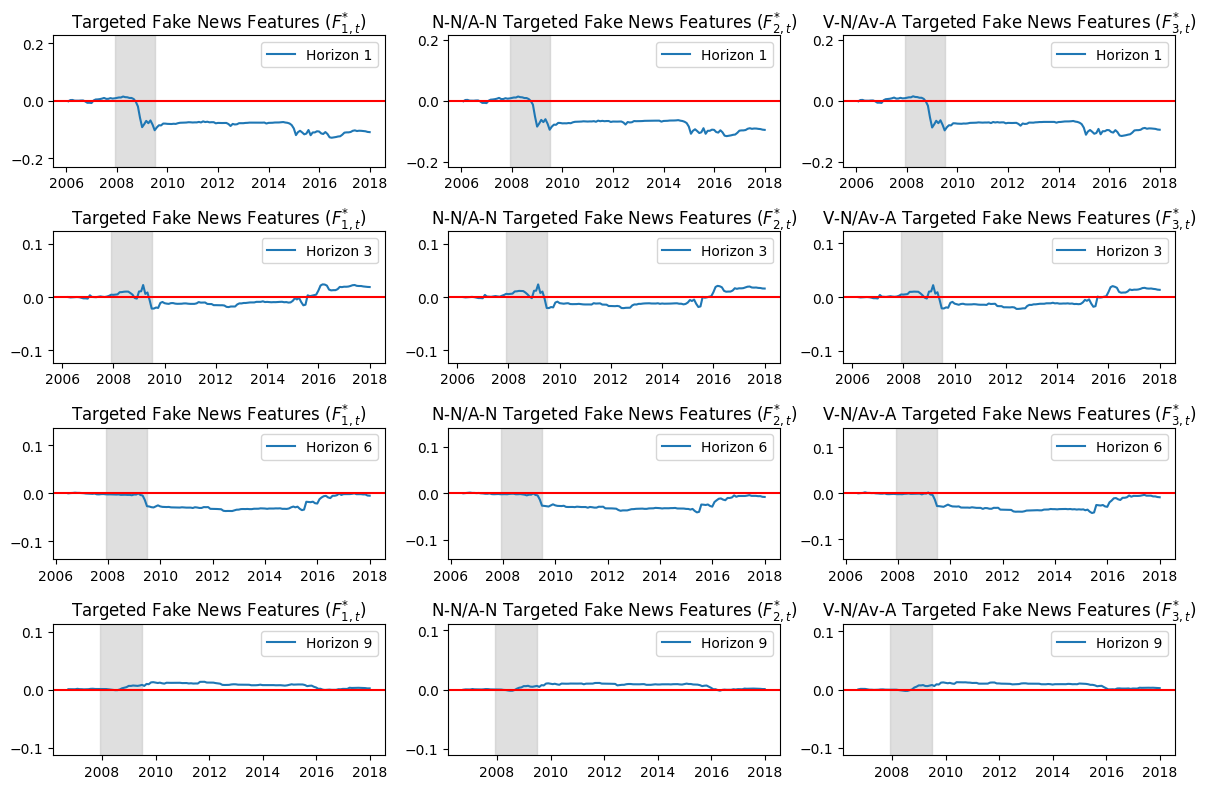

In [103]:
# Get list of models
models = list(predictions_dict_pca.keys())

# Dates of the Great Recession (according to NBER)
recession_start = pd.to_datetime('2007-12-01')
recession_end = pd.to_datetime('2009-06-30')

# The number of unique horizons
n_horizons = len(horizons)

# The number of unique models
n_models = len(models)

# Create grid of subplots: n_horizons rows and n_models columns
fig, axs = plt.subplots(n_horizons, n_models, figsize=(12, 2 * n_horizons))
axs = axs.ravel()  # Flatten array to easily iterate over it in a single loop

# Loop over each horizon
for h_idx, h in enumerate(horizons):
    # Loop over each model
    for m_idx, model_name in enumerate(models):
        ax = axs[n_models * h_idx + m_idx]  # Assign subplot position

        # Get AutoRegressive predictions for this model
        y_benchmark = np.array(predictions_ar_dict[model_name][h])

        # Get true values and predictions for this model and horizon
        y_true = np.array(y_true_ar_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])

        e1 = (y_true - y_pred) ** 2  # forecast errors from your model
        e2 = (y_true - y_benchmark) ** 2  # forecast errors from the benchmark model

        # Calculate CSPE for the model and benchmark
        cspe_model = np.cumsum(e1)
        cspe_benchmark = np.cumsum(e2)

        # Adjust dates based on the horizon
        dates = oos_base_dates[h-1:]

        # Plot CSPE
        y_values = cspe_benchmark - cspe_model
        ax.plot(dates, y_values, label=f'Horizon {h}')

        # Add a shaded region for the recession
        ax.axvspan(recession_start, recession_end, color='silver', alpha=0.5)

        ax.axhline(0, color='red', linestyle='-')
        # Set y-limit such that 0 is in the middle
        y_abs_max = max(abs(y_values.min()), abs(y_values.max()))
        ax.set_ylim(-y_abs_max-0.1, y_abs_max+0.1)

        ax.set_title(model_name)
        ax.legend()

plt.tight_layout()
plt.savefig('fake_ar_cspe.eps', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


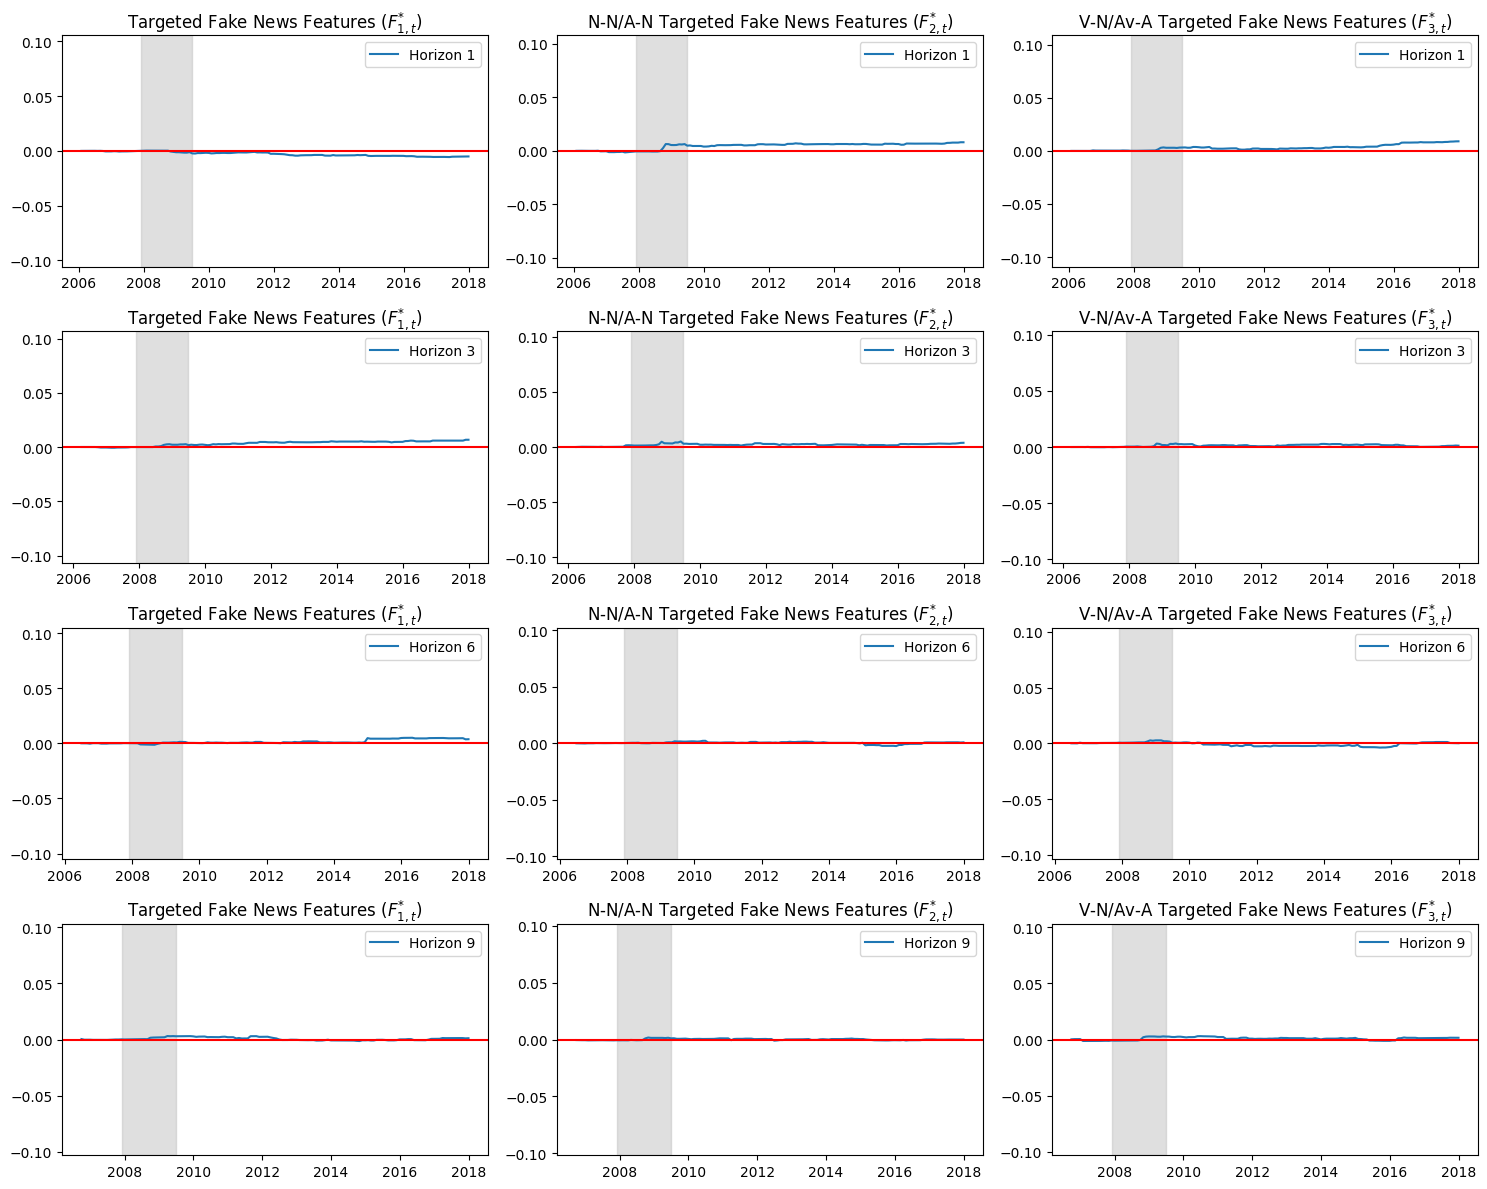

In [104]:
# Get list of models
models = list(predictions_dict_pca.keys())

# Dates of the Great Recession (according to NBER)
recession_start = pd.to_datetime('2007-12-01')
recession_end = pd.to_datetime('2009-06-30')

# The number of unique horizons
n_horizons = len(horizons)

# The number of unique models
n_models = len(models)

# Create grid of subplots: n_horizons rows and n_models columns
fig, axs = plt.subplots(n_horizons, n_models, figsize=(15, 3 * n_horizons))
axs = axs.ravel()  # Flatten array to easily iterate over it in a single loop

# Loop over each horizon
for h_idx, h in enumerate(horizons):
    # Loop over each model
    for m_idx, model_name in enumerate(models):
        ax = axs[n_models * h_idx + m_idx]  # Assign subplot position

        # Get AutoRegressive predictions for this model
        y_benchmark = np.array(predictions_historical_avg_dict[model_name][h])

        # Get true values and predictions for this model and horizon
        y_true = np.array(y_true_historical_avg_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])

        e1 = (y_true - y_pred) ** 2  # forecast errors from your model
        e2 = (y_true - y_benchmark) ** 2  # forecast errors from the benchmark model

        # Calculate CSPE for the model and benchmark
        cspe_model = np.cumsum(e1)
        cspe_benchmark = np.cumsum(e2)

        # Adjust dates based on the horizon
        dates = oos_base_dates[h-1:]

        # Plot CSPE
        y_values = cspe_benchmark - cspe_model
        ax.plot(dates, y_values, label=f'Horizon {h}')

        # Add a shaded region for the recession
        ax.axvspan(recession_start, recession_end, color='silver', alpha=0.5)

        ax.axhline(0, color='red', linestyle='-')
        # Set y-limit such that 0 is in the middle
        y_abs_max = max(abs(y_values.min()), abs(y_values.max()))
        ax.set_ylim(-y_abs_max-0.1, y_abs_max+0.1)

        ax.set_title(model_name)
        ax.legend()

plt.tight_layout()
plt.savefig('fake_ha_cspe.eps', dpi=300)
plt.show()

                                                                $$ THE   END $$